# Deep Learning Project 3 - Jailbreaking Deep Models

# Task 1

We start by testing ResNet-34 against the ImageNet dataset:

In [85]:
# Portions of this code were generated, then modified, with help from ChatGPT (https://chat.openai.com), May 2025

In [31]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import json
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained model
resnet34 = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device)
resnet34.eval()  # Set to evaluation mode

# Normalization parameters for ImageNet
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

inv_normalize = transforms.Normalize(
      mean=[-m/s for m, s in zip(mean_norms, std_norms)],
      std=[1/s for s in std_norms]
  )

# Modify class labels to fit the IMAGENET1K_V1 set
class OffsetLabels(ImageFolder):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        return image, label + 401

# Load dataset
dataset_path = "/content/drive/MyDrive/7123/P3/TestDataSet"  # Update if needed
dataset = OffsetLabels(root=dataset_path, transform=plain_transforms)
dataset_loader = DataLoader(dataset, batch_size=64, shuffle=False)

Using device: cuda


We can print our image classes and their numerical labels to get a better sense of the dataset:

In [32]:
with open(dataset_path + "/labels_list.json", "r") as f:
    raw_class_list = json.load(f)

print(raw_class_list)

['401: accordion', '402: acoustic guitar', '403: aircraft carrier', '404: airliner', '405: airship', '406: altar', '407: ambulance', '408: amphibian', '409: analog clock', '410: apiary', '411: apron', '412: ashcan', '413: assault rifle', '414: backpack', '415: bakery', '416: balance beam', '417: balloon', '418: ballpoint', '419: Band Aid', '420: banjo', '421: bannister', '422: barbell', '423: barber chair', '424: barbershop', '425: barn', '426: barometer', '427: barrel', '428: barrow', '429: baseball', '430: basketball', '431: bassinet', '432: bassoon', '433: bathing cap', '434: bath towel', '435: bathtub', '436: beach wagon', '437: beacon', '438: beaker', '439: bearskin', '440: beer bottle', '441: beer glass', '442: bell cote', '443: bib', '444: bicycle-built-for-two', '445: bikini', '446: binder', '447: binoculars', '448: birdhouse', '449: boathouse', '450: bobsled', '451: bolo tie', '452: bonnet', '453: bookcase', '454: bookshop', '455: bottlecap', '456: bow', '457: bow tie', '458: 

We'll define a function to evaluate the top-1 and top-5 accuracies for any given model and dataset:

In [33]:
from tqdm import tqdm

def evaluate_model_on_dataset(model, dataset_path, batch_size=64):
    print(f"Evaluating model on {dataset_path}...")
    eval_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_norms, std=std_norms),
    ])
    eval_dataset = OffsetLabels(root=dataset_path, transform=eval_transform)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

    correct_top1 = 0
    correct_top5 = 0
    total = 0

    with torch.no_grad():
        for images, labels in eval_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, pred_top5 = outputs.topk(5, dim=1)

            correct_top1 += (pred_top5[:, 0] == labels).sum().item()
            correct_top5 += sum([labels[i] in pred_top5[i] for i in range(len(labels))])
            total += labels.size(0)

    top1_acc = 100 * correct_top1 / total
    top5_acc = 100 * correct_top5 / total
    print(f"Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc:.2f}%")

evaluate_model_on_dataset(resnet34, dataset_path)

Evaluating model on /content/drive/MyDrive/7123/P3/TestDataSet...
Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


# Task 2 - FGSM Attack

A Fast Gradient Sign Method attack involves a single step of gradient descent in pixel space to modify our images. We start by defining the function for an attack on a single image, in which we first gather the sign of the cross-entropy loss gradient and then multiply it by our epsilon=0.02 before applying it to the image:

In [34]:
import torch.nn.functional as F

def fgsm_attack(model, images, labels, epsilon):
    images.requires_grad = True

    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()

    grad_sign = images.grad.data.sign()
    adv_images = images + epsilon * grad_sign
    adv_images = torch.clamp(adv_images, 0, 1)  # clamp after undoing normalization if needed
    return adv_images.detach()

We load the dataset without ImageNet transforms in order to effectively apply the attack in pixel space:

In [35]:
raw_transforms = transforms.Compose([
    transforms.ToTensor()
])
raw_dataset = OffsetLabels(root=dataset_path, transform=raw_transforms)
raw_dataloader = DataLoader(raw_dataset, batch_size=64, shuffle=False)

We'll predict our outputs before and after the FGSM attack so that we can visualize the results later:

In [36]:
resnet34.eval()
adversarial_examples = []
original_images = []
true_labels = []
preds_before = []
preds_after = []

mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

for images, labels in tqdm(raw_dataloader):
    images = images.to(device)
    labels = labels.to(device)

    # Save originals
    original_normalized = (images - mean) / std
    original_images.append(original_normalized.cpu())

    # Predict before attack
    with torch.no_grad():
        outputs = resnet34(images)
        preds_before.append(outputs.argmax(1).cpu())

    # FGSM attack
    adv_imgs = fgsm_attack(resnet34, images, labels, epsilon=0.02)

    adversarial_normalized = (adv_imgs - mean) / std
    adversarial_examples.append(adversarial_normalized.cpu())

    # Predict after attack
    with torch.no_grad():
        adv_out = resnet34(adv_imgs)
        preds_after.append(adv_out.argmax(1).cpu())

    true_labels.append(labels.cpu())

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


In [37]:
# Flatten tensors
original_images = torch.cat(original_images)
adversarial_examples = torch.cat(adversarial_examples)
true_labels = torch.cat(true_labels)
preds_before = torch.cat(preds_before)
preds_after = torch.cat(preds_after)

For any given sets of predictions and image sets, show 5 images that the model no longer classifies as expected:

In [69]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2025-05-11 02:07:06--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2025-05-11 02:07:07 (55.5 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [70]:
# Get full ImageNet class list
with open("imagenet_classes.txt") as f:
    class_names = [line.strip() for line in f]

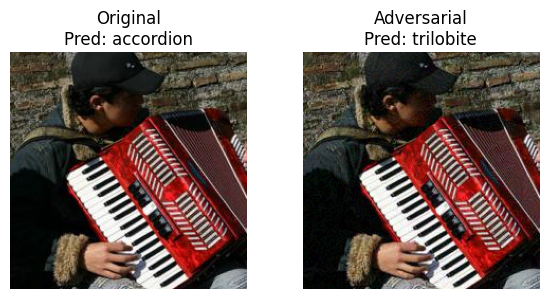

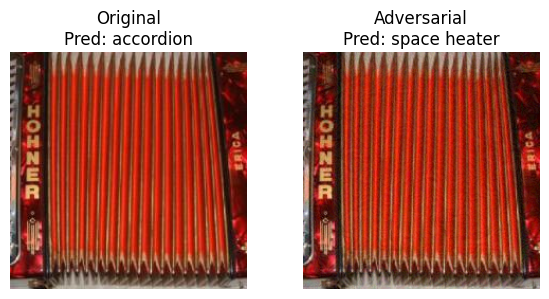

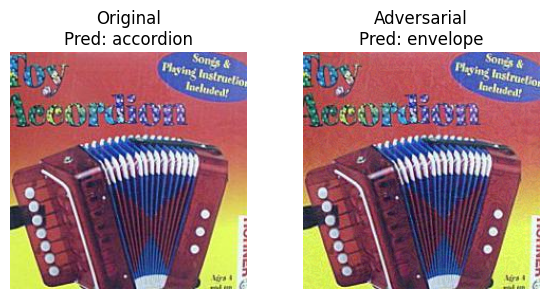

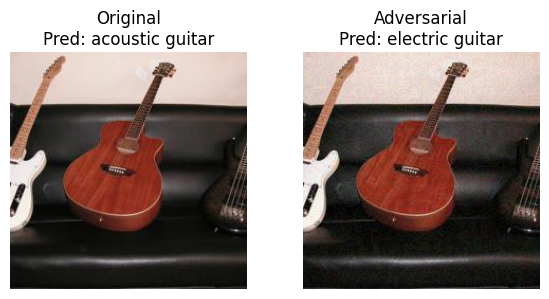

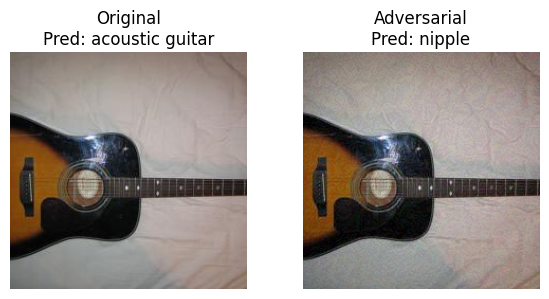

In [72]:
import matplotlib.pyplot as plt

def show_misclassified(preds_before, preds_after, images_before, images_after):
  # Find misclassified examples
  changed = (preds_before == true_labels) & (preds_after != true_labels)
  changed_idxs = torch.where(changed)[0][:5]

  for idx in changed_idxs:
      orig = inv_normalize(images_before[idx]).permute(1, 2, 0).detach().numpy()
      adv = inv_normalize(images_after[idx]).permute(1, 2, 0).detach().numpy()

      fig, axs = plt.subplots(1, 2, figsize=(6, 3))
      axs[0].imshow(orig)
      axs[0].set_title(f"Original\nPred: {class_names[preds_before[idx].item()]}")
      axs[0].axis("off")

      axs[1].imshow(adv)
      axs[1].set_title(f"Adversarial\nPred: {class_names[preds_after[idx].item()]}")
      axs[1].axis("off")

      plt.tight_layout()
      plt.show()

show_misclassified(preds_before, preds_after, original_images, adversarial_examples)

The L∞ distance should not be greater than the epsilon value we chose, so we can define a function to test this:

In [39]:
def test_L(original_imgs, changed_images):

  # Undo normalization to test L∞ distance
  orig_raw = inv_normalize(original_images)
  adv_raw = inv_normalize(changed_images)

  l_inf = (adv_raw - orig_raw).abs().view(adv_raw.size(0), -1).max(dim=1)[0]
  print(f"Max L∞ distance (raw space): {l_inf.max().item():1f}", )  # Should be ≤ epsilon

# Test the L∞ for our FGSM dataset
test_L(original_images, adversarial_examples)

Max L∞ distance (raw space): 0.020000


Finally, we'll save our dataset for later evaluation:

In [40]:
from torchvision.utils import save_image
import os

def save_dataset(save_root, images):

  os.makedirs(save_root, exist_ok=True)

  # Get the mapping from label index to folder name:
  idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

  for i in range(len(images)):
      img = inv_normalize(images[i].cpu())
      label = true_labels[i].item()
      folder_name = idx_to_class[label-401]
      save_dir = os.path.join(save_root, folder_name)
      os.makedirs(save_dir, exist_ok=True)

      save_path = os.path.join(save_dir, f"{i:04d}.png")
      save_image(torch.clamp(img, 0, 1), save_path)


In [41]:
adv_save_root = "./AdversarialTestSet1"
save_dataset(adv_save_root, adversarial_examples)

Our top-1 and top-5 accuracies should fall by at least 50% from our first test:

In [42]:
evaluate_model_on_dataset(resnet34, adv_save_root)

Evaluating model on ./AdversarialTestSet1...
Top-1 Accuracy: 10.20%
Top-5 Accuracy: 33.40%


Looks like we did it!

# Task 3 - PGD Attack

PGD (Projected Gradient Descent) is a powerful image attack which exploits specific vulnerabilities in the learning process of our ResNet model. We implement this through successive iterations in which we learn the direction of gradient ascent and multiply it by a chosen step size, keeping our perterbations within the perterbation budget epsilon:

In [43]:
def pgd_attack_raw_space(model, raw_image, label, epsilon, alpha, num_steps):
    orig = raw_image.clone().detach()
    perturbed = raw_image.clone().detach().to(device)
    perturbed.requires_grad = True

    for _ in range(num_steps):
        normed = (perturbed - mean) / std
        output = model(normed)
        loss = F.cross_entropy(output, label)
        model.zero_grad()
        loss.backward()

        # Gradient ascent step
        with torch.no_grad():
            grad_sign = perturbed.grad.sign()
            perturbed += alpha * grad_sign

            # Project back into epsilon-ball (L∞)
            perturbed = torch.max(torch.min(perturbed, orig + epsilon), orig - epsilon)
            perturbed = torch.clamp(perturbed, 0, 1)  # stay in valid image range
            perturbed.requires_grad = True

    return perturbed.detach()

We already have our predictions before the attack, so we only need to predict after the PGD attack:

In [73]:
pgd_images = []
preds_after_pgd = []

for images, labels in tqdm(raw_dataloader):
    images = images.to(device)
    labels = labels.to(device)

    # PGD attack
    pgd_imgs = pgd_attack_raw_space(resnet34, images, labels, epsilon=0.02, alpha=0.005, num_steps=10)

    pgd_normalized = (pgd_imgs - mean) / std
    pgd_images.append(pgd_normalized.cpu())

    # Predict after attack
    with torch.no_grad():
        pgd_out = resnet34(pgd_imgs)
        preds_after_pgd.append(pgd_out.argmax(1).cpu())

pgd_images = torch.cat(pgd_images)
preds_after_pgd = torch.cat(preds_after_pgd)

100%|██████████| 8/8 [00:23<00:00,  2.98s/it]


Let's see how our predictions changed:

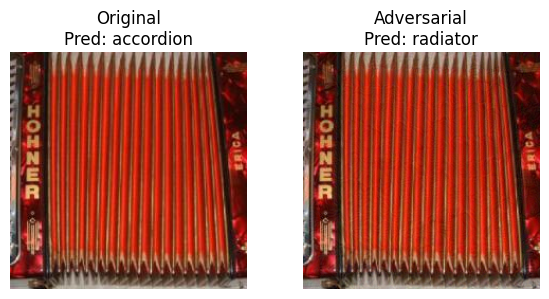

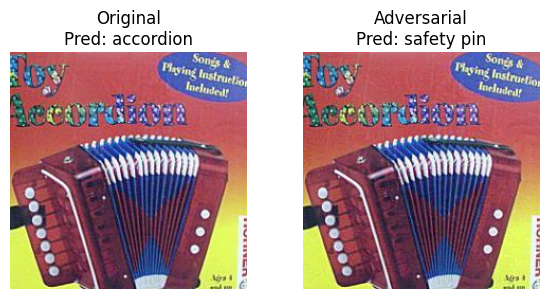

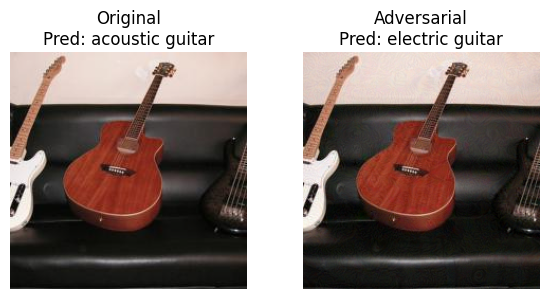

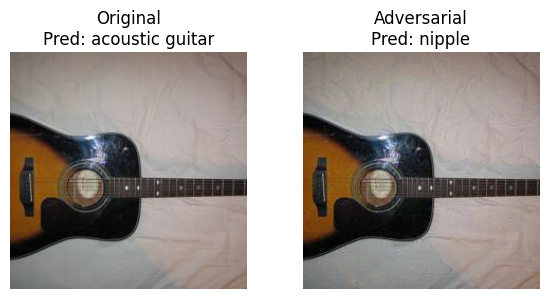

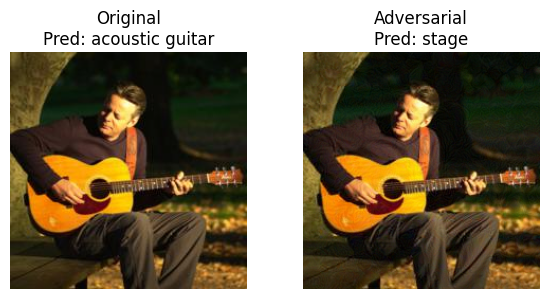

In [74]:
show_misclassified(preds_before, preds_after_pgd, original_images, pgd_images)

In [75]:
pgd_save_root = "./AdversarialTestSet2"
save_dataset(pgd_save_root, pgd_images)

In [76]:
evaluate_model_on_dataset(resnet34, pgd_save_root)

Evaluating model on ./AdversarialTestSet2...
Top-1 Accuracy: 0.00%
Top-5 Accuracy: 1.20%


As you can see, our accuracy fell greatly, and our L∞ distance remains within limits:

In [77]:
test_L(original_images, pgd_images)

Max L∞ distance (raw space): 0.020000


#Task 4 - Patch Attack

If we don't want to perturb the entire image, we can instead implement a patch attack that focuses on only a random 32x32 pixel area. We do this by first making a mask of the area, then applying the same PGD attack but with the mask applied:

In [78]:
def pgd_patch_attack(model, images, labels,
                           epsilon, alpha, num_steps, patch_size):
    # images: [B,3,224,224] in [0,1]
    orig = images.clone().detach().to(device)
    adv  = orig.clone().detach().to(device)
    adv.requires_grad = True

    # Build a fixed mask per sample
    mask = torch.zeros_like(adv)
    B, C, H, W = adv.shape
    for i in range(B):
        x = torch.randint(0, H - patch_size + 1, (1,)).item()
        y = torch.randint(0, W - patch_size + 1, (1,)).item()
        mask[i, :, x:x+patch_size, y:y+patch_size] = 1.0
    mask = mask.to(device)

    for _ in range(num_steps):
        # 1) forward pass on normalized adv
        normed = (adv - mean) / std
        out    = model(normed)
        loss   = F.cross_entropy(out, labels)
        model.zero_grad()
        loss.backward()

        # 2) step inside the same patch
        with torch.no_grad():
            grad_sign = adv.grad.sign()
            adv = adv + alpha * grad_sign * mask
            # project per‐pixel in patch to ±ε, clamp [0,1]
            adv = torch.max(torch.min(adv, orig + epsilon*mask),
                            orig - epsilon*mask)
            adv = torch.clamp(adv, 0.0, 1.0)
            adv.requires_grad = True

    return adv.detach()

To counteract the limited effectiveness of only attacking a small area, we apply the gradient descent with a higher step size and many more total steps:

In [80]:
preds_after_patch = []
patch_images = []

for images, labels in tqdm(raw_dataloader):
    images, labels = images.to(device), labels.to(device)

    adv = pgd_patch_attack(resnet34, images, labels,
                           epsilon=0.5, alpha=0.05, num_steps=70, patch_size=32)

    with torch.no_grad():
        normed_adv = (adv - mean) / std
        out_adv = resnet34(normed_adv)
        preds_after_patch.append(out_adv.argmax(1).cpu())
    patch_images.append(normed_adv.cpu())

100%|██████████| 8/8 [02:45<00:00, 20.71s/it]


In [81]:
patch_images      = torch.cat(patch_images)
preds_after_patch     = torch.cat(preds_after_patch)

As you can see, even changing a small patch can drastically change how our model sees an image:

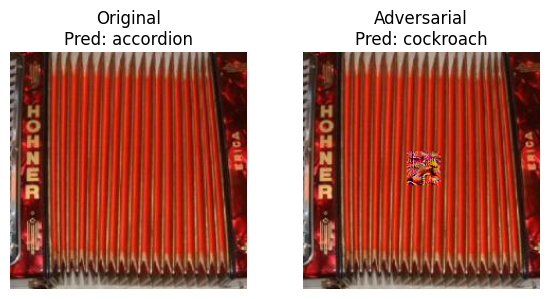

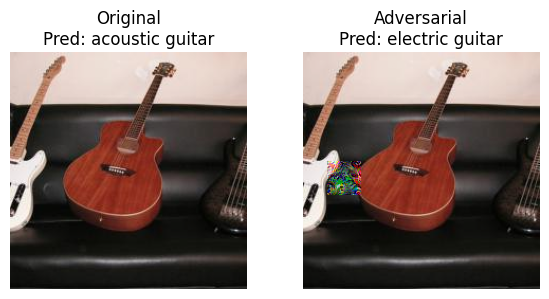

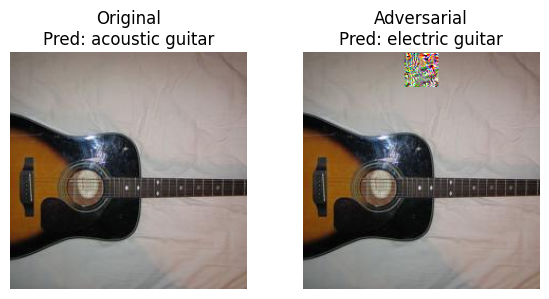

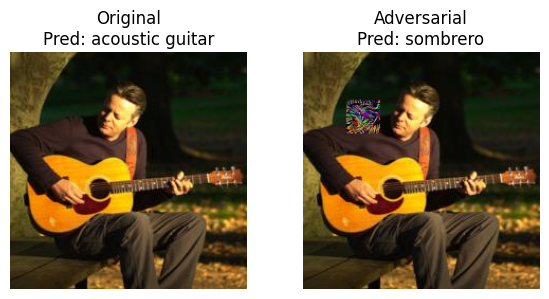

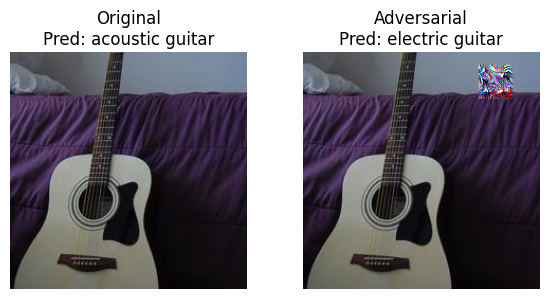

In [82]:
show_misclassified(preds_before, preds_after_patch, original_images, patch_images)

In [61]:
save_dataset("./AdversarialTestSet3", patch_images)

In [62]:
evaluate_model_on_dataset(resnet34, "./AdversarialTestSet3")

Evaluating model on ./AdversarialTestSet3...
Top-1 Accuracy: 3.40%
Top-5 Accuracy: 28.80%


Our results are almost as good as the original PGD attack!

In [63]:
test_L(original_images, patch_images)

Max L∞ distance (raw space): 0.500000


# Task 5 - Transferring attacks

Now that we have our 3 adversarial datasets saved, we can test them out on any other model, like DenseNet-121, or SqueezeNet. We'll run all 3 models on our datasets for easy comparisons:

In [84]:
densenet = torchvision.models.densenet121(weights='IMAGENET1K_V1').to(device)
densenet.eval()

squeezenet = torchvision.models.squeezenet1_1(weights="IMAGENET1K_V1").to(device)
squeezenet.eval()

models = {
    "ResNet-34": resnet34,
    "DenseNet-121": densenet,
    "SqueezeNet": squeezenet
}

datasets = {
    "Original Test Set": dataset_path,
    "Adversarial Test Set 1 (FGSM)": "./AdversarialTestSet1",
    "Adversarial Test Set 2 (PGD)": "./AdversarialTestSet2",
    "Adversarial Test Set 3 (Patch PGD)": "./AdversarialTestSet3",
}

for model_name, model in models.items():
  for dataset_name, path in datasets.items():
      print(f"\n→ Evaluating {model_name} on {dataset_name}:")
      evaluate_model_on_dataset(model, path)


→ Evaluating ResNet-34 on Original Test Set:
Evaluating model on /content/drive/MyDrive/7123/P3/TestDataSet...
Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%

→ Evaluating ResNet-34 on Adversarial Test Set 1 (FGSM):
Evaluating model on ./AdversarialTestSet1...
Top-1 Accuracy: 10.20%
Top-5 Accuracy: 33.40%

→ Evaluating ResNet-34 on Adversarial Test Set 2 (PGD):
Evaluating model on ./AdversarialTestSet2...
Top-1 Accuracy: 0.00%
Top-5 Accuracy: 1.20%

→ Evaluating ResNet-34 on Adversarial Test Set 3 (Patch PGD):
Evaluating model on ./AdversarialTestSet3...
Top-1 Accuracy: 3.40%
Top-5 Accuracy: 28.80%

→ Evaluating DenseNet-121 on Original Test Set:
Evaluating model on /content/drive/MyDrive/7123/P3/TestDataSet...
Top-1 Accuracy: 74.80%
Top-5 Accuracy: 93.60%

→ Evaluating DenseNet-121 on Adversarial Test Set 1 (FGSM):
Evaluating model on ./AdversarialTestSet1...
Top-1 Accuracy: 49.20%
Top-5 Accuracy: 78.00%

→ Evaluating DenseNet-121 on Adversarial Test Set 2 (PGD):
Evaluating model on .

Interestingly, the patch attack is much less effective at tricking our other 2 models, so further tweaking to our PGD Patch parameters may be needed.